In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image, ImageDraw

In [2]:
import ujson as json

In [3]:
from binary_file_parser import *

In [4]:
from data_utils import *

In [5]:
dataset = QuickDrawDataset()

Category: The Eiffel Tower. Finished processing 13043 images
Category: The Great Wall of China. Finished processing 17106 images


In [9]:
idx_split = dataset.get_idx_split()

{'train': tensor([13430, 12694, 12988,  ..., 28521,  5538, 22846]),
 'valid': tensor([  831, 14707, 19848,  ..., 26956,   983,  8033]),
 'test': tensor([ 5480, 28768, 14894,  ...,   860, 15795, 23654])}

In [ ]:
train_dataset = dataset[idx_split['train']]
valid_dataset = dataset[idx_split['valid']]
test_dataset = dataset[idx_split['test']]

In [12]:
great_wall_npy = f'./npy/full_numpy_bitmap_The Great Wall of China.npy'

In [5]:
great_wall_bin = f'./data/full_binary_The Great Wall of China.bin'

In [9]:
great_wall_ndjson = f'./data/full_simplified_The Great Wall of China.ndjson'

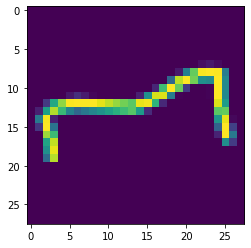

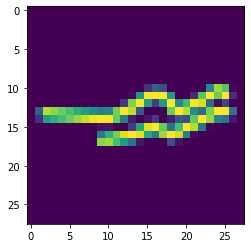

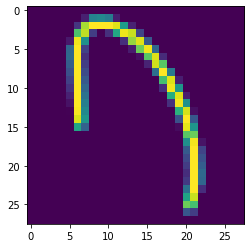

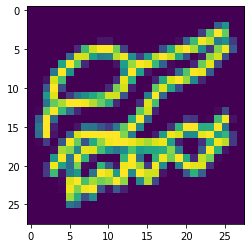

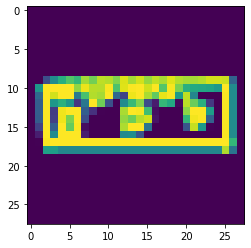

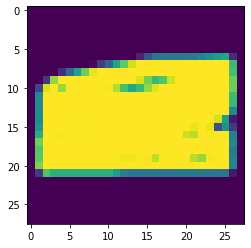

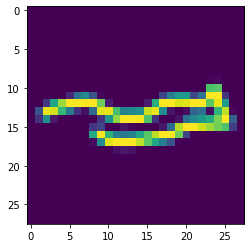

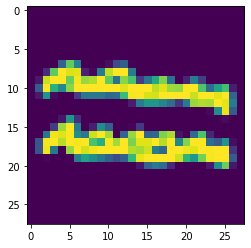

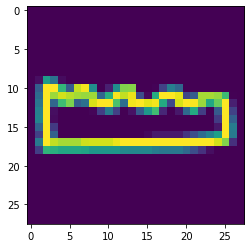

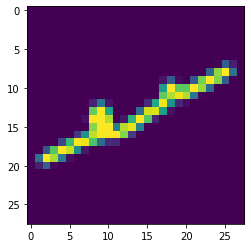

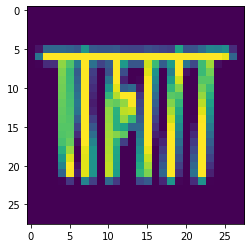

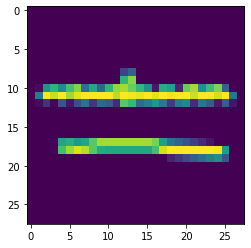

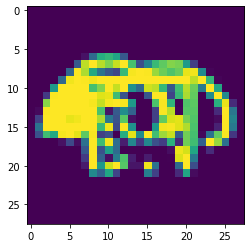

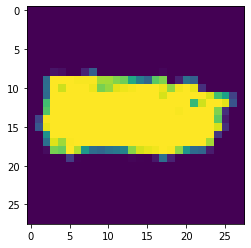

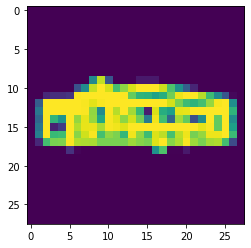

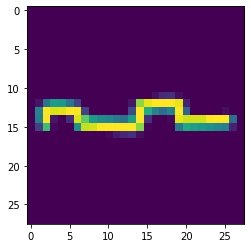

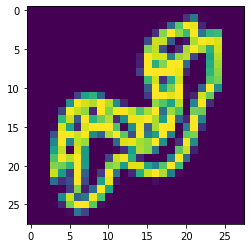

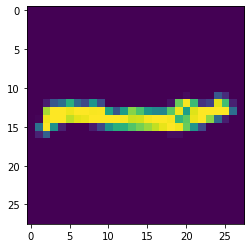

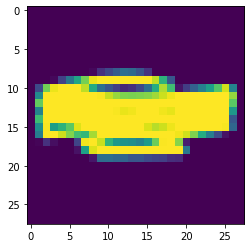

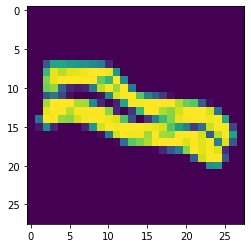

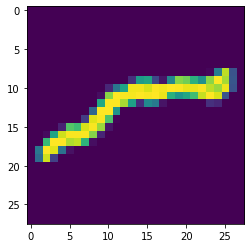

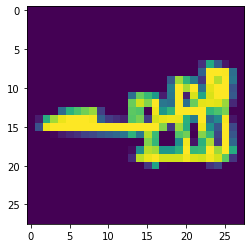

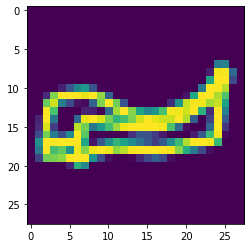

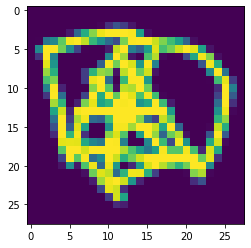

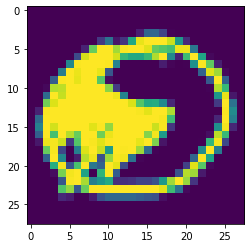

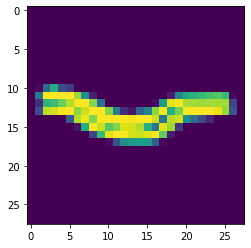

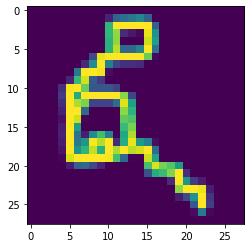

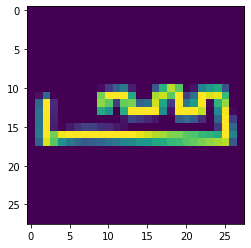

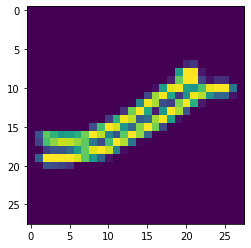

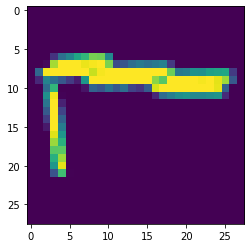

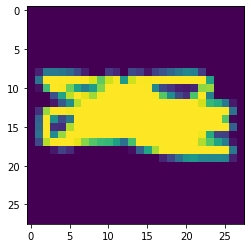

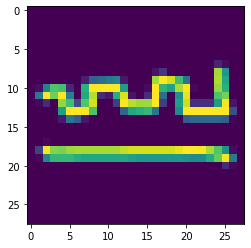

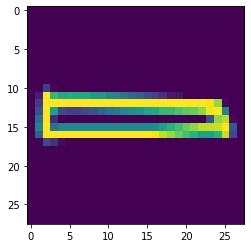

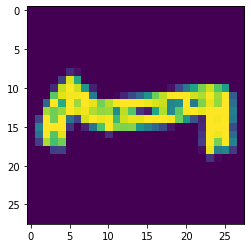

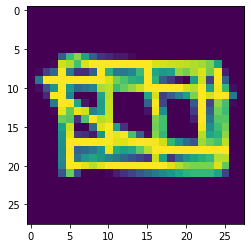

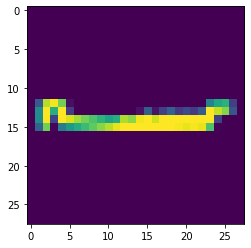

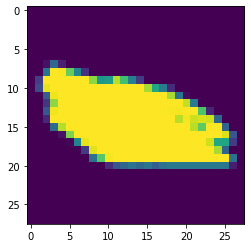

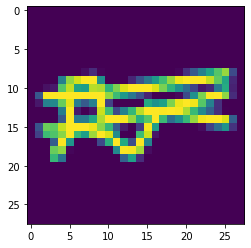

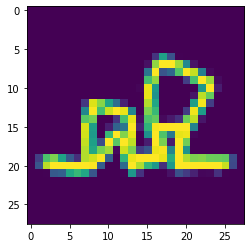

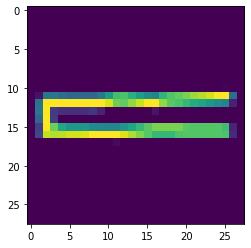

KeyboardInterrupt: 

In [10]:
for img in all_imgs:
    plt.imshow(img.reshape([28,28]))
    plt.show()

In [44]:
def open_ndjson(path: str) -> pd.DataFrame:
    """
    Pass in input filepath to ndjson, return pandas DataFrame.
    """
    records = map(json.loads, open(path, encoding="utf8"))
    return pd.DataFrame.from_records(records)

In [101]:
def rand_train_test_idx(n, train_prop=.5, valid_prop=.25):
    """ randomly splits label into train/valid/test splits """

    train_num = int(n * train_prop)
    valid_num = int(n * valid_prop)

    perm = torch.as_tensor(np.random.permutation(n))

    train_indices = perm[:train_num]
    val_indices = perm[train_num:train_num + valid_num]
    test_indices = perm[train_num + valid_num:]

    return train_indices, val_indices, test_indices

In [105]:
class QuickDrawDataset(Dataset):
    """QuickDraw Dataset, data sourced from Google."""
    
    def __init__(self, ndjson_directory="./ndjson", transform=None, prop=0.10):
        """
        Args:
            ndjson_directory (string): Path to the ndjson directory with sketch information.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        if ndjson_directory is None:
            download_data()
            ndjson_directory = f'./ndjson'
            
        height, width = 28, 28
        encoding_count = 0
        self.encoding = {}
        self.sketches = []
        self.labels = []
        
        for file in os.listdir(ndjson_directory):
            filename = os.fsdecode(file)
            if filename.endswith("ndjson"):
                # retaining only images that have been recognized
                df = open_ndjson(os.path.join(ndjson_directory, filename))
                df = df.loc[df.recognized, :]
                
                # creating one hot encoding for the string label
                self.encoding[encoding_count] = df.word.unique()[0]
                
                sample_count = int(len(df)*prop)
                
                # append array of sampled sketches to all sketches
                sample_imgs = vector_to_raster(df.drawing[:sample_count])
                self.sketches = self.sketches + sample_imgs
                print("Category: {}. Finished processing {} images"
                      .format(self.encoding[encoding_count], len(sample_imgs)))

                self.labels = self.labels + [encoding_count] * sample_count
                encoding_count += 1
            else:
                continue

        self.sketches = np.stack(self.sketches, axis=0).reshape((len(self.sketches), height, width))
        self.labels = np.asarray(self.labels)
        
        self.transform = transform
    
    def get_idx_split(self, train_prop=.5, valid_prop=.25):
        """
        train_prop: The proportion of dataset for train split. Between 0 and 1.
        valid_prop: The proportion of dataset for validation split. Between 0 and 1.
        """
        train_idx, valid_idx, test_idx = rand_train_test_idx(len(self.sketches), 
                                                             train_prop=train_prop, 
                                                             valid_prop=valid_prop)
        split_idx = {'train': train_idx,
                     'valid': valid_idx,
                     'test': test_idx}
        return split_idx

    def __len__(self):
        return len(self.sketches)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img = torch.from_numpy(self.sketches[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label